## Imports

In [1]:
%matplotlib inline
import numpy as np
from numpy import random
import random
import math
import matplotlib.pyplot as plt
from operator import add
import itertools
import seaborn as sns
import nest


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: May 19 2024 15:53:53

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
import os
import sys
Path = os.getcwd()
sys.path.append(Path)
from utilities1 import *
from build_network import *

In [3]:
def color_plot(a_values, SD_values, second_sine=False, f=10, sim_time=100e3, beat=20, fontsize=16, save_fig=False):
    ymax_fft = 0
    array = np.zeros((len(a_values),len(SD_values)))
    array_fft = np.zeros((len(a_values),len(SD_values)))
    
    for i, a in enumerate(a_values):
        for j, sd in enumerate(SD_values):
            
            results = build_simulation(sim_time=sim_time, noisy=True, f1=f, a=a, SD=sd, resolution=0.25,
                                      second_sine=second_sine, beat=beat)
            
            spike_times = results["spike_times"]
            spikes = len(spike_times)
            array[i,j] = 1000*spikes/sim_time
            freqs, psd_values = psd(spike_times, sim_time, bin_size=0.25)
            idx_f = np.argmin(np.abs(freqs - f))  #finner nærmeste indeks til f
            if second_sine:
                idx_f = np.argmin(np.abs(freqs - beat))
            
            if len(spike_times) > 0:
                array_fft[i, j] = np.abs(psd_values[idx_f])#np.abs(fft_values[idx_f])/len(spike_times)
            else:
                array_fft[i, j] = 0
       
    fig, ax = plt.subplots(ncols=2, figsize=(20,8))        
    im = ax[0].imshow(array, cmap="PuBuGn_r", vmin=np.min(array), vmax=np.max(array),
                      aspect="auto", origin="lower")
    ax[0].set_xticks(np.arange(len(SD_values)))  
    ax[0].set_xticklabels([f"{sd:.0f}" for sd in SD_values], rotation=45) 
    ax[0].set_yticks(np.arange(len(a_values)))
    ax[0].set_yticklabels([f"{a:.0f}" for a in a_values])  
    ax[0].set_xlabel(r"$\sigma_I$ [pA]", color="#006D5B", fontsize=16)
    ax[0].set_ylabel(r"$I_{\mathrm{amp}}$ [pA]", color="#006D5B", fontsize=16)
    ax[0].set_title("A. Firing rate vs. $I_{\mathrm{amp}}$ and $\sigma_I$", fontsize=fontsize, color="#006D5B", fontweight='bold')
    ax[0].tick_params(axis='x', labelsize=16)
    ax[0].tick_params(axis='y', labelsize=16)
    cbar = fig.colorbar(im, ax=ax[0])
    cbar.set_label("[Spikes/sec]", color="#006D5B", fontsize=16)  
    cbar.ax.yaxis.set_tick_params(color="#006D5B", labelsize=16) 
    print("Min log10:", np.min(np.log10(array_fft + 1e-12)))
    print("Max log10:", np.max(np.log10(array_fft + 1e-12)))
          
    imf = ax[1].imshow(array_fft, cmap="PuBuGn_r", vmin=np.min(array_fft), vmax=np.max(array_fft),
                       aspect="auto", origin="lower")
    ax[1].set_xticks(np.arange(len(SD_values)))  
    ax[1].set_xticklabels([f"{sd:.0f}" for sd in SD_values], rotation=45)  
    ax[1].set_yticks(np.arange(len(a_values)))
    ax[1].set_yticklabels([f"{a:.0f}" for a in a_values])  
    ax[1].set_xlabel("$\sigma_I$ [pA]", color="#006D5B", fontsize=16)
    ax[1].set_ylabel("$I_{\mathrm{amp}}$ [pA]", color="#006D5B", fontsize=16)
    ax[1].set_title("B. Power at $f=20\,\mathrm{Hz}$ vs. $I_{\mathrm{amp}}$ and $\sigma_I$", fontsize=fontsize, color="#006D5B", fontweight='bold') 
    ax[1].tick_params(axis='x', labelsize=16)
    ax[1].tick_params(axis='y', labelsize=16)
    cbar = fig.colorbar(imf, ax=ax[1])
    cbar.set_label(r"[$\mathrm{spikes}^2/\mathrm{Hz}$]", color="#006D5B", fontsize=16)
    cbar.ax.yaxis.set_tick_params(color="#006D5B", labelsize=16) 
    plt.tight_layout()
    if save_fig:
        save_figure("heatmaps")
    
    plt.show()
            


May 09 11:07:51 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 0.25 ms

May 09 11:07:51 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.25 ms.
Min log10: -12.0
Max log10: 5.0661682951780715
Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/heatmaps.png


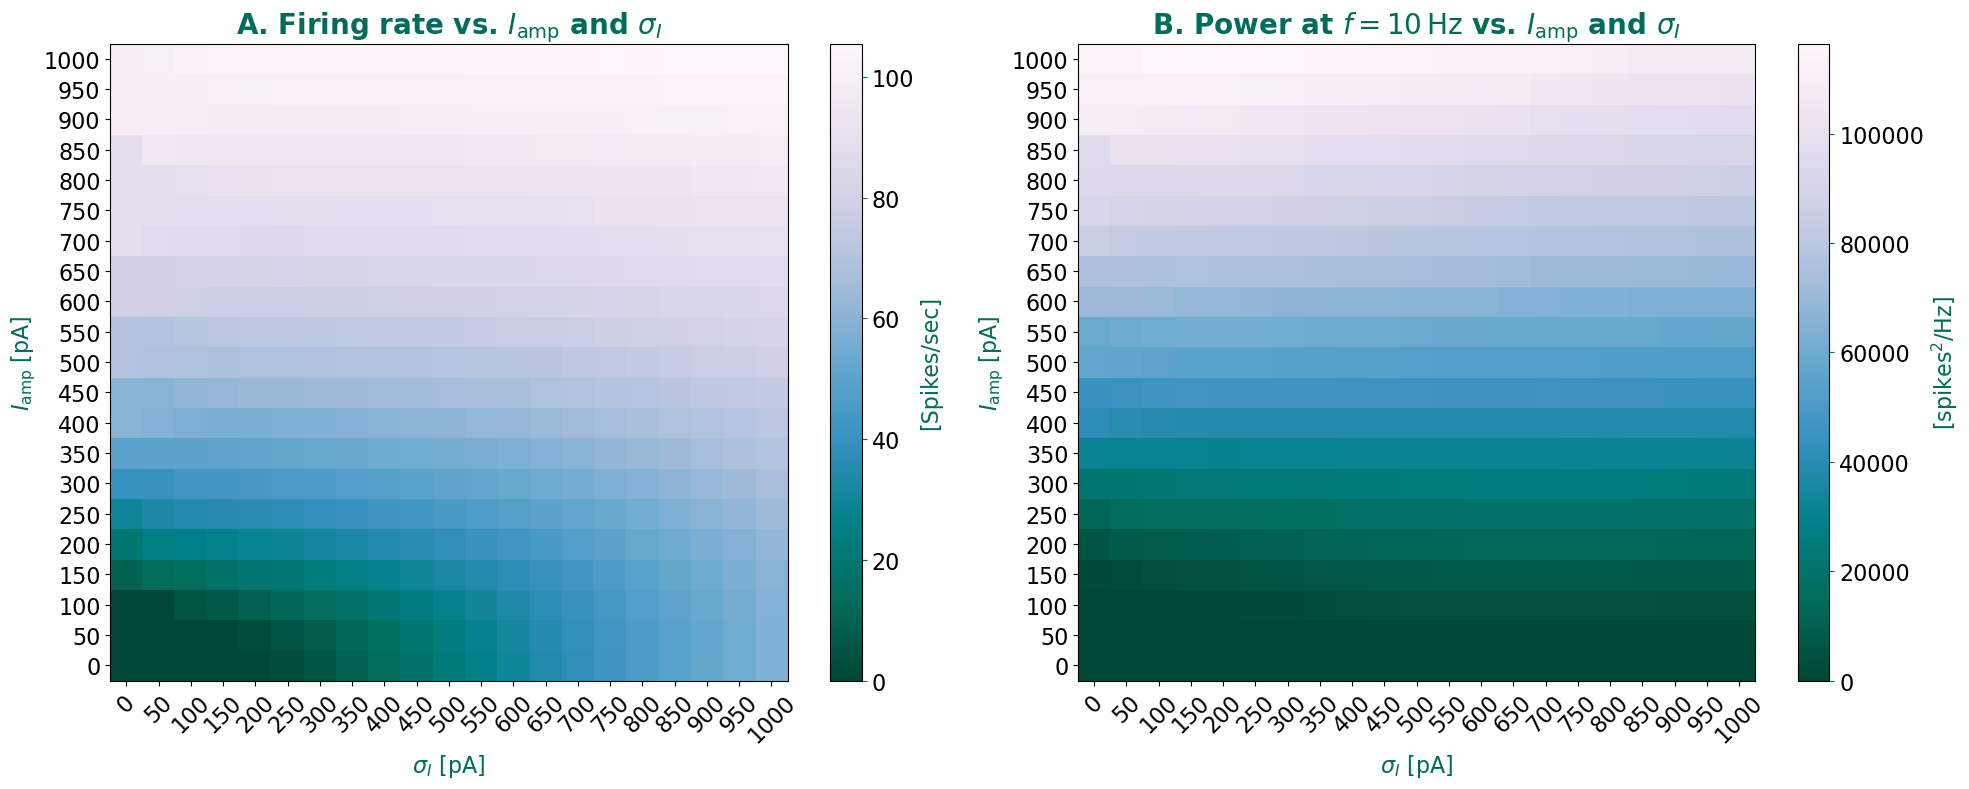

In [7]:
color_plot(a_values=np.linspace(0,1000,21), SD_values=np.linspace(0,1000,21), fontsize=20, save_fig=True)

Min log10: -12.0
Max log10: 4.253401545939167
Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/heatmaps.png


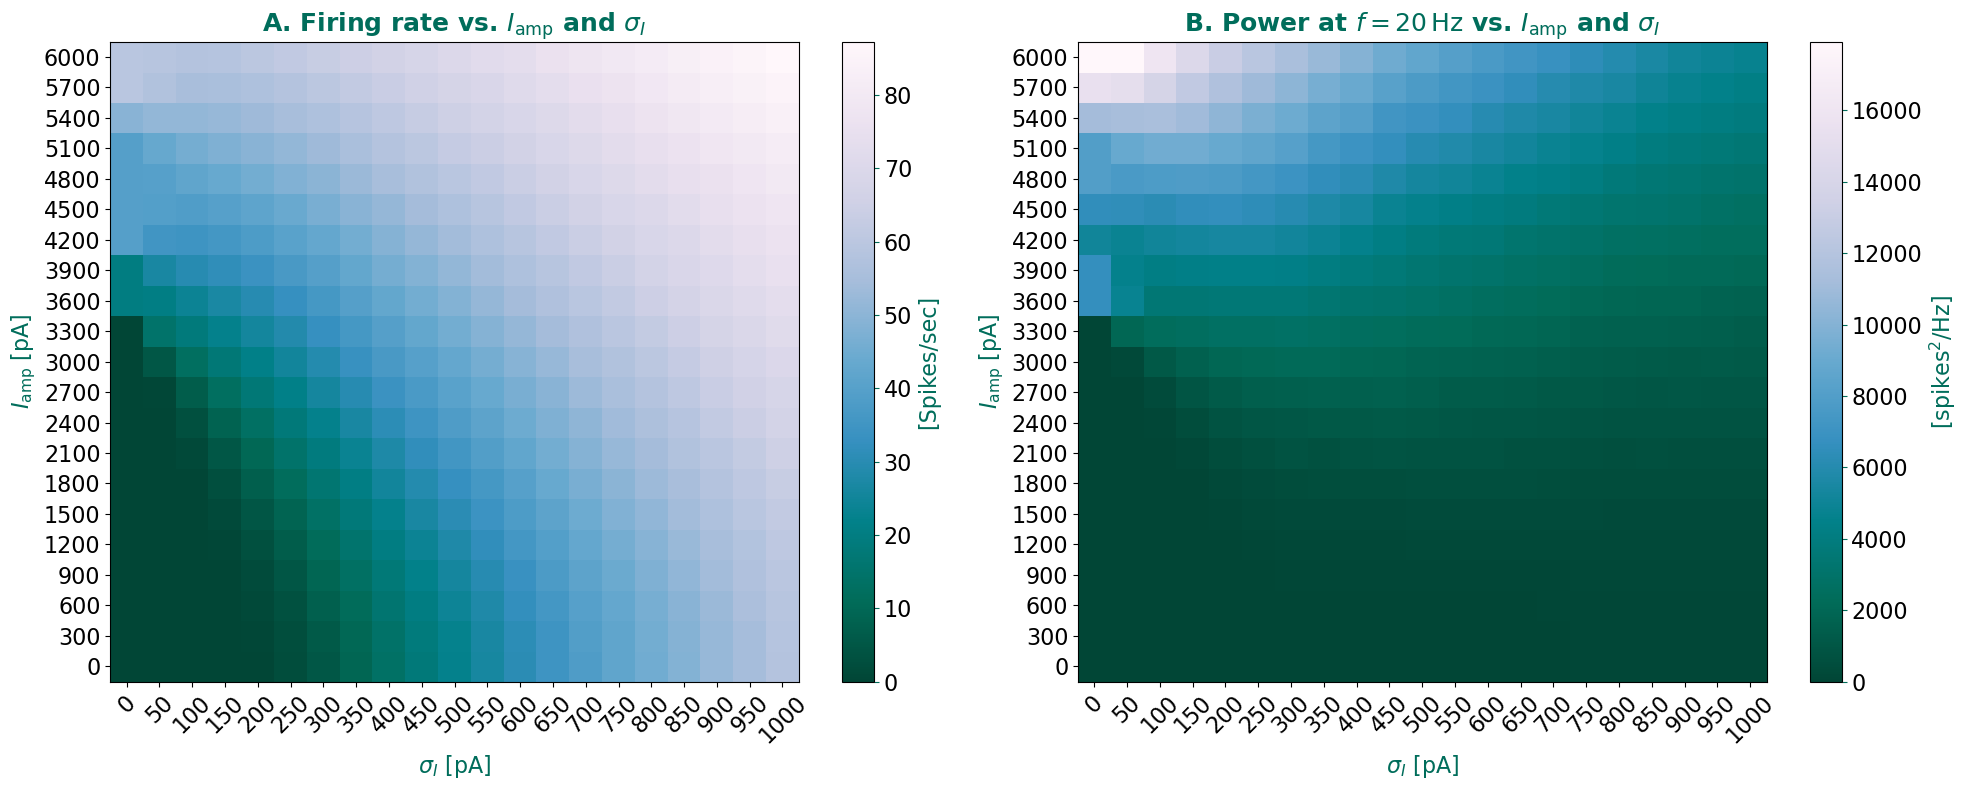

In [9]:
color_plot(a_values=np.linspace(0,6000,21), SD_values=np.linspace(0,1000,21), sim_time=100e3, f=1000, second_sine=True, beat=20,
           fontsize=18, save_fig=True)

In [11]:
"""Parsevals theorem"""
def heatmap_psd_sum(a_values, SD_values, second_sine=False, f=10, sim_time=10e3, beat=20, fontsize=16, save_fig=False):
    ymax_fft = 0
    array = np.zeros((len(a_values),len(SD_values)))
    array_fft = np.zeros((len(a_values),len(SD_values)))
    
    plt.rcParams["font.family"] = "Liberation Serif"
    
    for i, a in enumerate(a_values):
        for j, sd in enumerate(SD_values):
            
            results = build_simulation(sim_time=sim_time, noisy=True, f1=f, a=a, SD=sd, resolution=0.5,
                                      second_sine=second_sine, beat=beat)
            
            spike_times = results["spike_times"]
            spikes = len(spike_times)
            array[i,j] = 1000*spikes/sim_time
            freqs, psd_values = psd(spike_times, sim_time, bin_size=0.2)
            idx_f = np.argmin(np.abs(freqs - f))  #finner nærmeste indeks til f
            
            
            if len(spike_times) > 0:
                array_fft[i, j] = np.sum(psd_values)#np.abs(fft_values[idx_f])/len(spike_times)
            else:
                array_fft[i, j] = 0
            
            diff_psd_fr = array[i,j]-array[i,j]
           
            if diff_psd_fr != 0:
                print("value not identical. Diff:", diff_psd_fr)
    fig, ax = plt.subplots(ncols=2, figsize=(20,8))        
    im = ax[0].imshow(array, cmap="PuBuGn_r", vmin=np.min(array), vmax=np.max(array),
                      aspect="auto", origin="lower")
    ax[0].set_xticks(np.arange(len(SD_values)))  
    ax[0].set_xticklabels([f"{sd:.0f}" for sd in SD_values], rotation=45) 
    ax[0].set_yticks(np.arange(len(a_values)))
    ax[0].set_yticklabels([f"{a:.0f}" for a in a_values])  
    ax[0].set_xlabel(r"$\sigma_I$ [pA]", color="#006D5B", fontsize=18)
    ax[0].set_ylabel(r"$I_{\mathrm{amp}}$ [pA]", color="#006D5B", fontsize=18)
    ax[0].set_title("A. Firing rate vs. $I_{\mathrm{amp}}$ and $\sigma_I$", fontsize=20, color="#006D5B", fontweight='bold')
    ax[0].tick_params(axis='x', labelsize=14)
    ax[0].tick_params(axis='y', labelsize=14)
    cbar = fig.colorbar(im, ax=ax[0])
    cbar.set_label("Spikes per second", color="#006D5B", fontsize=18)  
    cbar.ax.yaxis.set_tick_params(color="#006D5B", labelsize=16) 
    print("Min log10:", np.min(np.log10(array_fft + 1e-12)))
    print("Max log10:", np.max(np.log10(array_fft + 1e-12)))
          
    imf = ax[1].imshow(array_fft, cmap="PuBuGn_r", vmin=np.min(array_fft), vmax=np.max(array_fft),
                       aspect="auto", origin="lower")
    ax[1].set_xticks(np.arange(len(SD_values)))  
    ax[1].set_xticklabels([f"{sd:.0f}" for sd in SD_values], rotation=45)  
    ax[1].set_yticks(np.arange(len(a_values)))
    ax[1].set_yticklabels([f"{a:.0f}" for a in a_values])  
    ax[1].set_xlabel("$\sigma_I$ [pA]", color="#006D5B", fontsize=18)
    ax[1].set_ylabel("$I_{\mathrm{amp}}$ [pA]", color="#006D5B", fontsize=18)
    ax[1].set_title("B. PSD of spike train vs. $I_{\mathrm{amp}}$ and $\sigma_I$", fontsize=fontsize, color="#006D5B", fontweight='bold') 
    ax[1].tick_params(axis='x', labelsize=14)
    ax[1].tick_params(axis='y', labelsize=14)
    cbar = fig.colorbar(imf, ax=ax[1])
    cbar.set_label("PSD", color="#006D5B", fontsize=18) 
    cbar.ax.yaxis.set_tick_params(color="#006D5B", labelsize=16) 
    plt.tight_layout()
    if save_fig:
        save_figure("heatmaps")
    
    plt.show()
            
        

Min log10: -12.0
Max log10: 6.797409455357034
Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/heatmaps.png


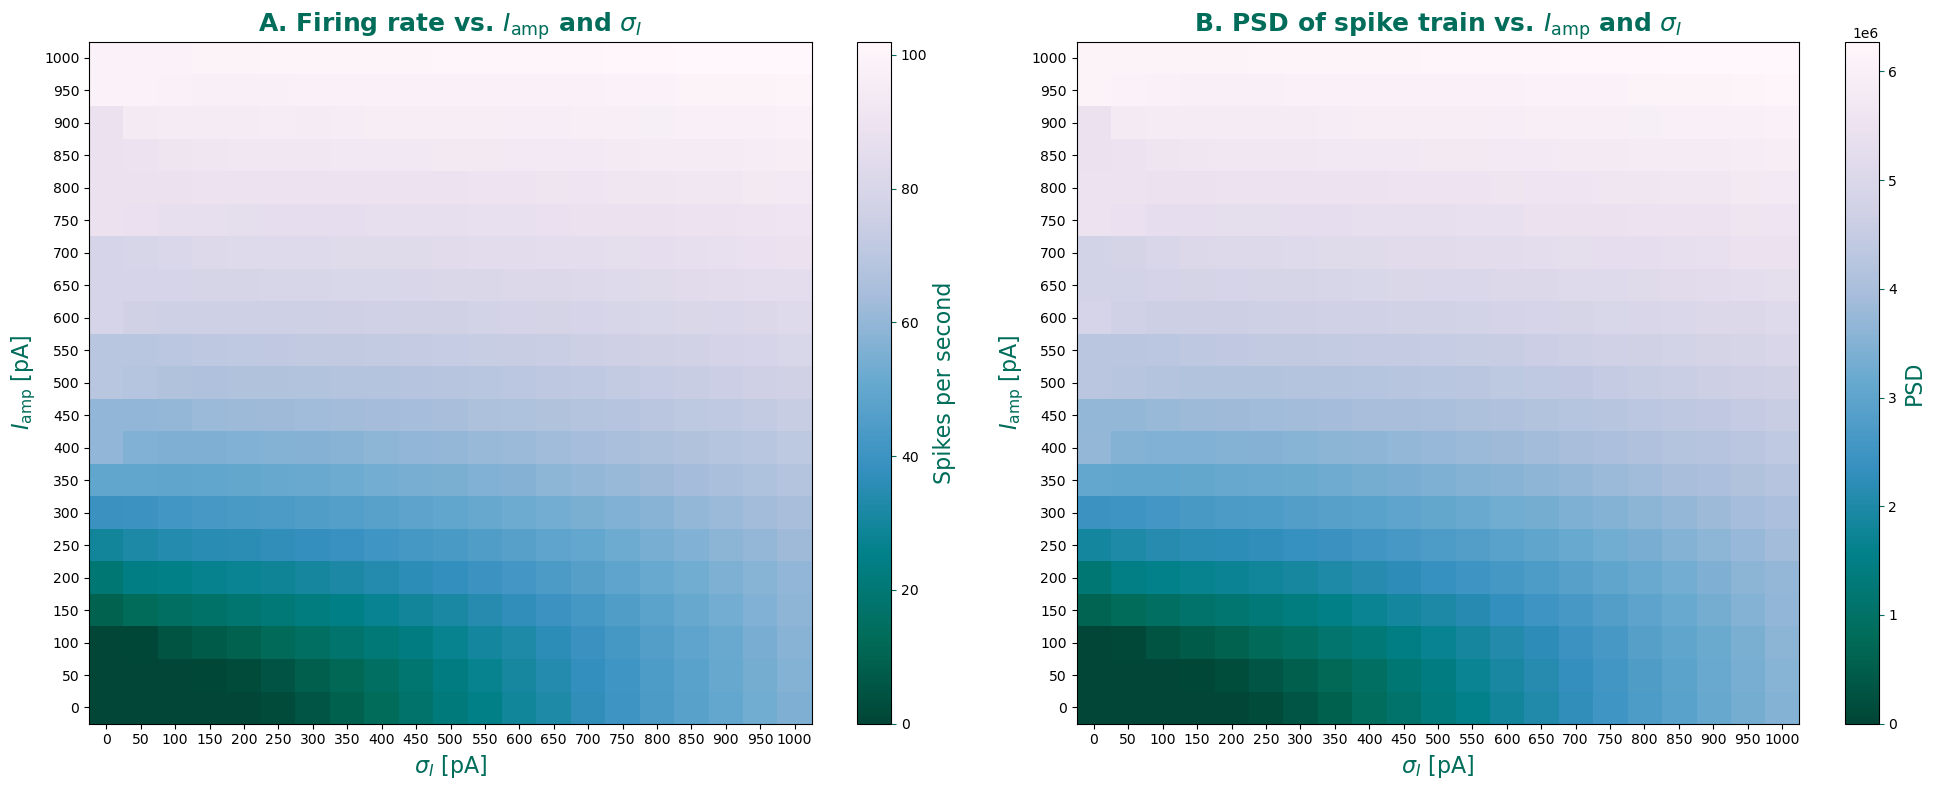

In [18]:
heatmap_psd_sum(a_values=np.linspace(0,1000,21), SD_values=np.linspace(0,1000,21), sim_time=100e3, f=10, second_sine=False, beat=20,
           fontsize=20, save_fig=True)

Min log10: -12.0
Max log10: 6.701300845863148
Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/heatmaps.png


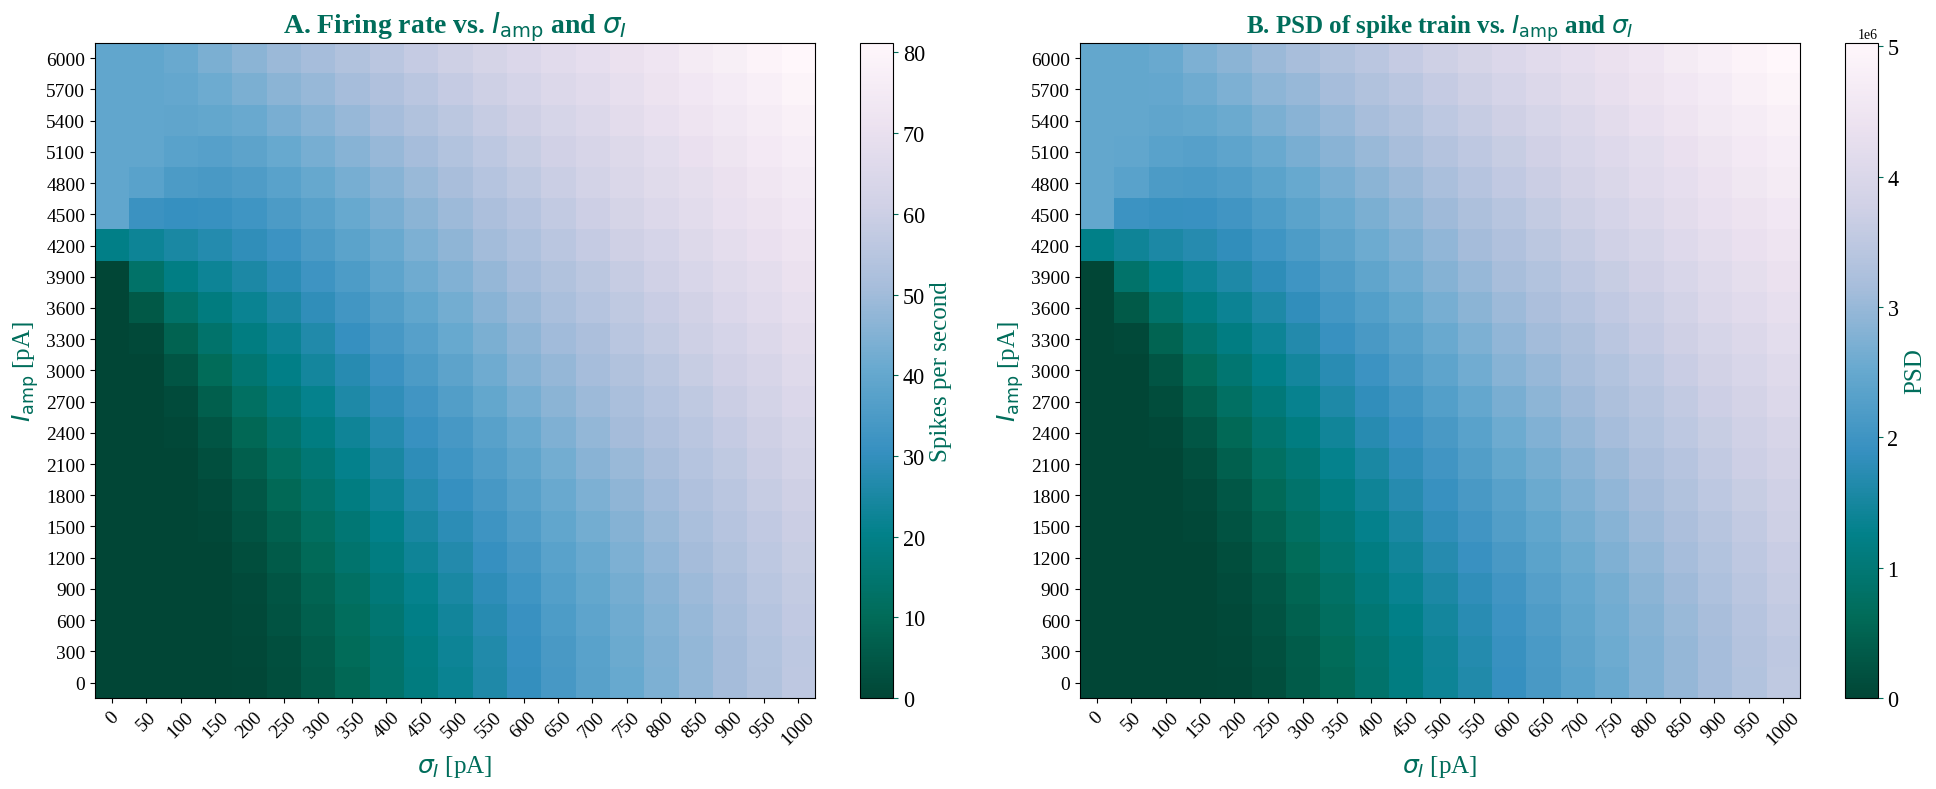

In [12]:
heatmap_psd_sum(a_values=np.linspace(0,6000,21), SD_values=np.linspace(0,1000,21), sim_time=100e3, f=1000, second_sine=True, beat=20,
           fontsize=18, save_fig=True)

In [3]:
import time

def snr_heatmap(a_values, num_A_values, window=5,  sim_time=100e3, save_fig=False, f=1000):
    start = time.time()
    plt.rcParams["font.family"] = "Liberation Serif"
    
    print(f"simulation time: {sim_time}")
    beat = 20
    resolution = 0.25
    bin_size = 0.25

    
    x_labels = [f"{N_A:.0f}" for N_A in num_A_values]
    array_snr = np.zeros((len(a_values), len(num_A_values)))
    
    for i, a in enumerate(a_values):
        for j, N_A in enumerate(num_A_values):
            results = build_network(sim_time=sim_time, num_A=N_A, weight=1,
                                    noisy=True, second_sine=True, beat=beat,
                                    f1=f, a=a, SD=250,
                                    resolution=resolution)
    
            spike_times = results["spike_times"]
            
            if len(spike_times) > 0:
                freqs, psd_values = psd(spike_times, sim_time, bin_size=bin_size, segments=16)
                psd_values = np.abs(psd_values)
                if len(freqs) == 0 or len(psd_values) == 0:
                    print(f"[ADVARSEL] Tom PSD for a={a}, N={N_A}")
                    array_snr[i, j] = 0
                    continue
                    
                arg_f_beat = np.argmin(np.abs(freqs - beat))
                signal = psd_values[arg_f_beat]
                noise_mask = (freqs >= freqs[arg_f_beat] - window) & (freqs <= freqs[arg_f_beat] + window)
                noise = np.mean(psd_values[noise_mask])
    
                snr = signal / noise if noise > 0 else 0
                array_snr[i, j] = snr
            else:
                array_snr[i, j] = 0
        print(a)
        print("spikerate:", spike_times/len(spike_times))
    
    # --- Plot heatmap ---
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(array_snr, cmap="PuBuGn_r", origin="lower", aspect="auto")
    
    ax.set_xticks(np.arange(len(num_A_values)))
    ax.set_xticklabels([f"{N:.0f}" for N in num_A_values])
    ax.set_yticks(np.arange(len(a_values)))
    ax.set_yticklabels([f"{a:.0f}" for a in a_values])
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel(r"$N_A$", fontsize=16, color="#006D5B")
    #ax.set_xlabel(r"$N_A \cdot w$ [pA]", fontsize=14, color="#006D5B")
    ax.set_ylabel(r"$I_{\mathrm{amp}}$ [pA]", fontsize=16, color="#006D5B")
    ax.set_title("SNR[f=1000] vs. input amplitude and number of neurons", fontsize=20, color="#006D5B", fontweight='bold')
    
    cbar = fig.colorbar(im)
    cbar.set_label("SNR", color="#006D5B", fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    
    plt.tight_layout()
    if save_fig:
        plt.savefig("snr_heatmap_1000.png", dpi=300)
    
    plt.show()
    
    end = time.time()
    print("Time elapsed:", end - start)
    

simulation time: 100000.0

May 09 15:45:15 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 0.25 ms

May 09 15:45:15 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.25 ms.
delay: [0.79472616 0.90283527 1.12460204 1.17514805 0.70996698 1.25523323
 1.08839939 1.40585528 0.85588783 0.58863081]

May 09 15:45:15 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.
delay: [1.55224532 0.91497808 0.65263745 0.50131734 1.31199452 1.07173249
 1.07155282 0.99002071 0.70220624 1.71169566]

May 09 15:45:23 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.
delay: [0.67359274 0.84277505 0.9083189  1.02395932 1.12467861 0.90948494
 0.95455644 1.43950993 0.72699514 1.0983062 ]

May 09 15:45:38 ConnectionManager [Warning]: 
    New connections cre

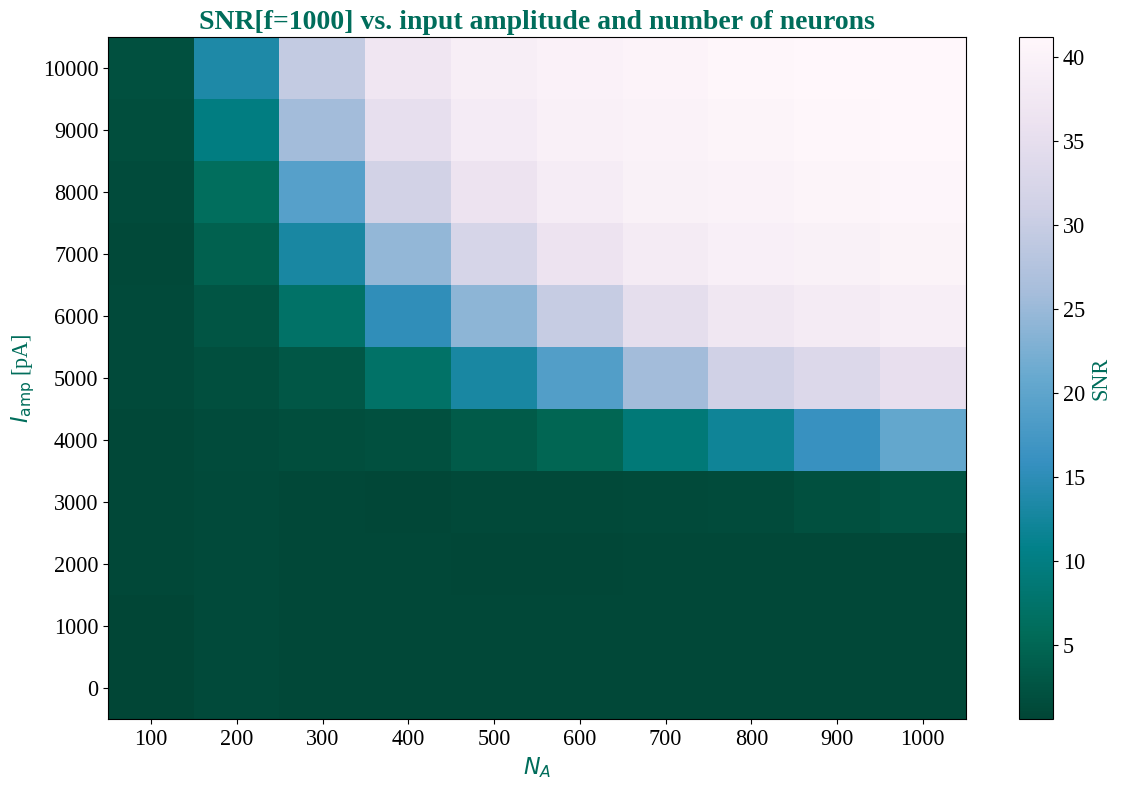

Time elapsed: 5318.457528591156


In [4]:
snr_heatmap(a_values=np.linspace(0,10000,11), num_A_values=np.linspace(100,1000,10, dtype=int),
            sim_time=100e3, save_fig=True)